In [1]:
import warnings
import string
import joblib
import multiprocessing
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
from pandas.core.common import flatten
from tqdm.notebook import tqdm
from collections import defaultdict

import torch
import transformers
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import re
import emoji
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore")

In [2]:
def transform_df(df, by="finance", k=10):
    """
    Parameters: 
        df: DataFrame
        by: "forex", "finance", "politics"
        k: int
    """
    # Group tweets by date and aggregate into a list
    df_temp = df.copy()
    df_temp = df_temp.sort_values(['date', 'finance'], ascending=False).groupby('date').head(100)
    df_temp = df_temp.groupby("date")['clean_tweet'].agg(list)
    df_temp = df_temp.reset_index(drop=False, inplace=False)
    df_temp.columns = ["date", "agg_tweets"]
    
    # Create top k tweet columns
    new_cols = ["Top {} Tweet".format(i+1) for i in range(k)]
    df_temp = df_temp.assign(**dict.fromkeys(new_cols, np.NaN))
    
    # Update every columns
    for index, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
        try:
            i = 1
            for tweet in row["agg_tweets"]:
                column = "Top {} Tweet".format(i)
                df_temp.loc[index, column] = tweet
                i += 1
                if i > k:
                    break
        except:
            pass
    df = df_temp.drop("agg_tweets", axis=1)
    
    return df
        
df = joblib.load("../data/df_final_v3.gzip")
df_tweet = transform_df(df, by="finance", k=20)
df_tweet["date"] = pd.to_datetime(df_tweet["date"])

In [3]:
df_tweet.head()

,date,Top 1 Tweet,Top 2 Tweet,Top 3 Tweet,Top 4 Tweet,Top 5 Tweet,Top 6 Tweet,Top 7 Tweet,Top 8 Tweet,Top 9 Tweet,...,Top 11 Tweet,Top 12 Tweet,Top 13 Tweet,Top 14 Tweet,Top 15 Tweet,Top 16 Tweet,Top 17 Tweet,Top 18 Tweet,Top 19 Tweet,Top 20 Tweet
0,2017-01-01,Forex Of A Basis Of Financial Literacy Of Torr...,Forex trading Dollar| url fx forex fb fx forex...,"RichestLearn Forex Trading Crash Course, FX Tr...",trading forex binaryoptions Introduction to Fi...,Chart: The Most Traded Currencies in 2016 url...,url url Business Analyst Insurance - Kelly...,An insider is guide to CFD is and forex tradin...,trading forex binaryoptions USD/CHF Long on br...,How To trade the Forex Market| url fx forex fb...,...,"Sterling squeezes higher, cad rate decision ne...",Forex Trading Signals| url fx forex fb fx fore...,download Stoclye High Low Middle forex trading...,"""How High Can The Price Of Bitcoin Rise?"" by T...",News: The final forex closing levels for 2016 ...,Forex Trump Trading| url fx forex fb fx forex ...,"Maximum Profits, Minimum Time - binary Options...",Learn about forex trading| url fx forex fb fx ...,News: China Said to Boost Scrutiny of Foreign ...,MYREALESTATEBRAINDOTCOM SWFL REALESTATE ECONOM...
1,2017-01-03,"On Forbes' list of Most Powerful People,\nObam...",New Glaeser paper on real estate bubbles sugge...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-04,China leading financial reformer Peoples Bank ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-05,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-06,Haruhiko Kuroda: A new phase of the global eco...,bis Haruhiko Kuroda: A new phase of the global...,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
fx = pd.read_csv("../data/Currency_Data_GBPUSD.csv", index_col=False)
fx.columns = ["currecny", "date", "Open", "High", "Low", "Close"]
fx["date"] = pd.to_datetime(fx["date"])
fx.sort_values(by='date', inplace=True)
fx.reset_index(drop=True, inplace=True)
fx["label"] = fx["Close"].diff(periods=1)
fx.dropna(inplace=True)
fx.drop("currecny", axis=1, inplace=True)
fx["label"] = fx["label"].map(lambda x: 1 if float(x)>=0 else 0)

In [5]:
tweet_and_fx = pd.merge(df_tweet, fx, on=["date"])
tweet_and_fx.set_index('date', inplace=True)
del df_tweet, fx
tweet_and_fx.head()

,Top 1 Tweet,Top 2 Tweet,Top 3 Tweet,Top 4 Tweet,Top 5 Tweet,Top 6 Tweet,Top 7 Tweet,Top 8 Tweet,Top 9 Tweet,Top 10 Tweet,...,Top 16 Tweet,Top 17 Tweet,Top 18 Tweet,Top 19 Tweet,Top 20 Tweet,Open,High,Low,Close,label
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,"On Forbes' list of Most Powerful People,\nObam...",New Glaeser paper on real estate bubbles sugge...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.2416,1.2419,1.2281,1.2319,0
2017-01-06,Haruhiko Kuroda: A new phase of the global eco...,bis Haruhiko Kuroda: A new phase of the global...,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.2890,1.2916,1.2830,1.2885,1
2017-01-13,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.2187,1.2233,1.2122,1.2182,0
2017-01-19,"Interview with Haruhiko Kuroda, Governor of th...","Interview with Haruhiko Kuroda, Governor of th...",Here is the transcript of atUser chat with atU...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.2310,1.2341,1.2254,1.2302,0
2017-01-20,Global economy at a turning point says Bank of...,Haruhiko Kuroda of BoJ discusses Japans growth...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.2302,1.2380,1.2261,1.2375,1


In [6]:
train = tweet_and_fx.loc[:"2019-08-25"]
valid = tweet_and_fx.loc["2019-08-25":"2020-02-24"]
test = tweet_and_fx.loc["2020-02-24":]

In [7]:
class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.targets = df.label.values
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.len = len(self.df)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, item):
        top_1, top_2, top_3 = self.df.iloc[item, 1:4].values
        target = self.targets[item]
        
        encoding_1 = self.tokenizer.encode_plus(
            str(top_1), 
            max_length=self.max_len, 
            add_special_tokens=True, 
            return_token_type_ids=False, 
            pad_to_max_length=True, 
            return_attention_mask=True, 
            return_tensors="pt")
        
        encoding_2 = self.tokenizer.encode_plus(
            str(top_2), 
            max_length=self.max_len, 
            add_special_tokens=True, 
            return_token_type_ids=False, 
            pad_to_max_length=True, 
            return_attention_mask=True, 
            return_tensors="pt")
        
        encoding_3 = self.tokenizer.encode_plus(
            str(top_3), 
            max_length=self.max_len, 
            add_special_tokens=True, 
            return_token_type_ids=False, 
            pad_to_max_length=True, 
            return_attention_mask=True, 
            return_tensors="pt")
        
        return {
            "tweet_text_1": str(top_1), 
            "tweet_text_2": str(top_2), 
            "tweet_text_3": str(top_3), 
            "input_ids_1": encoding_1["input_ids"].flatten(), 
            "input_ids_2": encoding_2["input_ids"].flatten(), 
            "input_ids_3": encoding_3["input_ids"].flatten(), 
            "attention_mask_1": encoding_1["attention_mask"].flatten(), 
            "attention_mask_2": encoding_2["attention_mask"].flatten(), 
            "attention_mask_3": encoding_3["attention_mask"].flatten(), 
            "target": torch.tensor(target, dtype=torch.long)
        }
    
def create_dataloader(df, tokenizer, max_len, batch_size):
    dataset = TweetDataset(
        df=df,  
        tokenizer=tokenizer, 
        max_len=max_len)
    
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0)

BATCH_SIZE = 16
MAX_LEN = 64

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
train_dataloader = create_dataloader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = create_dataloader(valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = create_dataloader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [8]:
def matthews_correlation_coefficient(true_pos, true_neg, false_pos, false_neg):
    nominator = (true_pos*true_neg-false_pos*false_neg) 
    denominator = np.sqrt((true_pos+false_pos)*(true_pos+false_neg)*(true_neg+false_pos)*(true_neg+false_neg)) + 1e-7
    return (nominator / denominator)

In [9]:
class ForexMovementClassifier(nn.Module):
    def __init__(self, n_classes, p=0.25):
        super(ForexMovementClassifier, self).__init__()
        self.bert_layer_1 = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.bert_layer_2 = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.bert_layer_3 = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.dropout = nn.Dropout(p=p)
        self.classifier = nn.Linear(self.bert_layer_1.config.hidden_size*3, n_classes)
        
    def forward(self, input_ids_1, input_ids_2, input_ids_3, 
                attention_mask_1, attention_mask_2, attention_mask_3):
        _, pooled_output_1 = self.bert_layer_1(
            input_ids=input_ids_1, 
            attention_mask=attention_mask_1)
        _, pooled_output_2 = self.bert_layer_2(
            input_ids=input_ids_2, 
            attention_mask=attention_mask_2)
        _, pooled_output_3 = self.bert_layer_3(
            input_ids=input_ids_3, 
            attention_mask=attention_mask_3)
        branch_1 = self.dropout(pooled_output_1)
        branch_2 = self.dropout(pooled_output_2)
        branch_3 = self.dropout(pooled_output_3)
        main = torch.cat([branch_1, branch_2, branch_3], 1)
        return F.softmax(self.classifier(main), dim=1)

RANDOM_SEED = 417
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_name = ["down", "up"]
torch.cuda.empty_cache()
model = ForexMovementClassifier(len(class_name))
model.to(device)
PATH = "../checkpoint/best_bert_20200701.bin"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for data in data_loader:
            input_ids_1 = data["input_ids_1"].to(device)
            input_ids_2 = data["input_ids_2"].to(device)
            input_ids_3 = data["input_ids_3"].to(device)
            attention_mask_1 = data["attention_mask_1"].to(device)
            attention_mask_2 = data["attention_mask_2"].to(device)
            attention_mask_3 = data["attention_mask_3"].to(device)
            targets = data["target"].to(device)

            outputs = model(input_ids_1, input_ids_2, input_ids_3, 
                            attention_mask_1, attention_mask_2, attention_mask_3)
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return predictions, prediction_probs, real_values

In [11]:
y_pred, y_pred_probs, y_test = get_predictions(model, test_dataloader)
print(classification_report(y_test, y_pred, target_names=class_name, zero_division=0))

              precision    recall  f1-score   support

        down       1.00      0.04      0.08        23
          up       0.35      1.00      0.52        12

    accuracy                           0.37        35
   macro avg       0.68      0.52      0.30        35
weighted avg       0.78      0.37      0.23        35



In [13]:
y_pred = np.where(y_pred>0, 1, -1)
y_pred

array([ 1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1])

In [14]:
class Strategy(object):

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_signals(self):
        raise NotImplementedError("Should implement generate_signals()!")
        
class Portfolio(object):

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_positions(self):
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        raise NotImplementedError("Should implement backtest_portfolio()!")

        
class RandomForecastingStrategy(Strategy):   
    
    def __init__(self, symbol, bars):
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = np.sign(np.random.randn(len(signals)))
        return signals
    
class MarketIntradayPortfolio(Portfolio):
    
    def __init__(self, symbol, bars, signals, initial_capital=100000, trading_sum=100):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.trading_sum = float(trading_sum)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
        positions[self.symbol] = self.trading_sum*self.signals['signal']
        return positions
                    
    def backtest_portfolio(self):
        portfolio = pd.DataFrame(index=self.positions.index)
        pos_diff = self.positions.diff()
        
        
        portfolio['price_diff'] = self.bars['Close']-self.bars['Open']
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']

        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio
    
class MachineLearningForecastingStrategy(Strategy):   
    
    def __init__(self, symbol, bars, pred):
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self, pred):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = pred
        return signals
    
def model_backtesting(pred, test, model_name, currency_name, initial_capital=100000, trading_sum=10000):
    test['Close'] = test['Close'].shift(-1)
    rfs = MachineLearningForecastingStrategy(currency_name, test, pred)
    signals = rfs.generate_signals(pred)
    portfolio = MarketIntradayPortfolio(currency_name, test, signals, initial_capital, trading_sum)
    returns = portfolio.backtest_portfolio()
    
    returns['signal'] = signals
    our_pct_growth = returns['total'].pct_change().cumsum()
    benchmark_ptc_growth = test['Close'].pct_change().cumsum()
    
    plt.figure(figsize=(20, 8))
    plt.subplot(2, 1, 1)
    plt.plot(returns['total'])
    plt.title("Total Return on {} using {}".format(currency_name, model_name))
    plt.grid()
    
    plt.subplot(2, 1, 2)
    plt.plot(our_pct_growth, label = 'ML long/short strategy', linewidth=2)
    plt.plot(benchmark_ptc_growth, linestyle = '--', label = 'Buy and hold strategy', linewidth=2)
    plt.title("ML Strategy V.S. Buy and Hold Strategy\nModel: {}\nCurrecy: {}".format(model_name, currency_name))
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    return returns

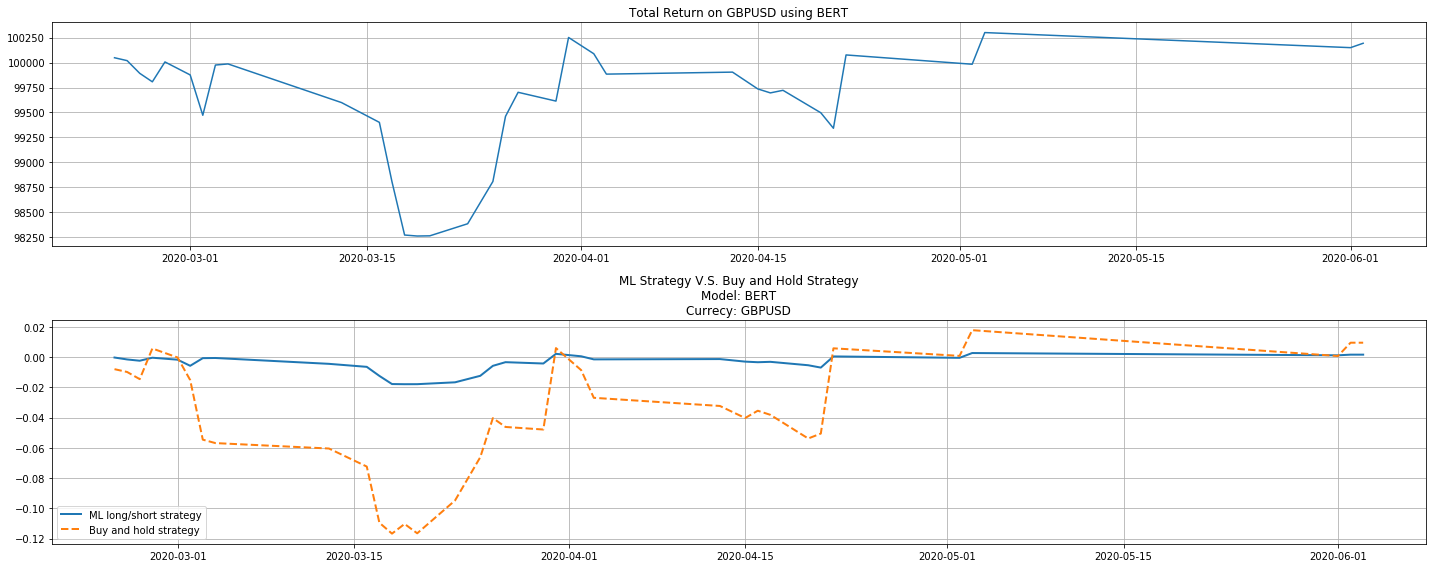

,price_diff,profit,total,returns,signal
date,,,,,
2020-02-24,0.0048,48.0,100048.0,NaN,1
2020-02-25,-0.0029,-29.0,100019.0,-0.000290,1
2020-02-26,-0.0127,-127.0,99892.0,-0.001270,1
2020-02-27,-0.0085,-85.0,99807.0,-0.000851,1
2020-02-28,0.0199,199.0,100006.0,0.001994,1
2020-03-01,-0.0130,-130.0,99876.0,-0.001300,1
2020-03-02,-0.0404,-404.0,99472.0,-0.004045,1
2020-03-03,-0.0503,503.0,99975.0,0.005057,-1
2020-03-04,0.0011,11.0,99986.0,0.000110,1


In [15]:
returns = model_backtesting(y_pred, test, "BERT", "GBPUSD")
returns

In [16]:
R = returns.returns.cumsum()

# Compute sharpe ratio
r = (R - R.shift(1))/R.shift(1)
sr = r.mean()/r.std() * np.sqrt(252)
sr

0.4629897986654341